<a href="https://colab.research.google.com/github/blid11/Group9/blob/Brett/BrettG9_PartC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combined Ideas


I have been created the 4 model - random forest, logistic regression, SVM, and Multilayer perception.
number of features depend on the cumulatife explained variance ratio (generally chossing number which >= 90%) 

In [ ]:
# Import libaries needed
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import scale # scale and canter data
from sklearn.svm import SVC # make a svm for classification
from sklearn.model_selection import GridSearchCV # do cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draw confutionm matrix
from sklearn.decomposition import PCA # perform PAC to plot the data
import matplotlib.pyplot as plt
from matplotlib import style 
import numpy as np
import seaborn as sns


In [4]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/My Drive/G9A2/G9
 
#%cd gdrive/My Drive/G9A2
# I made a folder on my google drive that has the G9 Methylation data and the binfpy library
#this code automatically loads it in
# you can do the same with your google drive. 
# restart runtime if you experience errors!

Mounted at /content/gdrive
/content/gdrive/My Drive/G9A2/G9


In [ ]:
!ls

G9_liver_dna-meth.csv	mystery_dna-meth.csv
G9_liver_gene-expr.csv	mystery_gene-expr.csv


In [71]:
# load the data 
liver_gene = pd.read_csv('G9_liver_gene-expr.csv', index_col=0)
liver_methyl = pd.read_csv('G9_liver_dna-meth.csv', index_col=0)

mys_gene = pd.read_csv("mystery_gene-expr.csv", index_col=0) 
mys_methyl = pd.read_csv("mystery_dna-meth.csv",index_col=0)

In [ ]:
liver_gene.head(n=2)

,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,X..280660,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
TCGA.2V.A95S.01,Primary Tumor,0.0,1.5051,3.7074,90.1124,1017.1038,0.0,141.3911,0.6516,0.0,...,24.7597,273.6602,794.2662,18.2440,499.1041,3172.5037,890.0472,510.1808,3.9094,6.5157
TCGA.2Y.A9GS.01,Primary Tumor,0.0,26.4120,2.6663,71.0054,639.2311,0.0,122.7206,1.4786,0.0,...,68.5067,632.8241,1153.7703,71.4638,1000.4929,5301.1336,755.5446,860.5224,6.4071,482.9966


In [ ]:
liver_methyl.head(n=2)

## 1. Data Preparation



### 1.1 Data Cleaning
- Rows without labels should be removed. 
- Separate Data and Labels
- NA values may need to be replaced for impute functions to work.

#### Separate Data and Labels

In [72]:
# Data for liver datasets
liver_gene_data = liver_gene[liver_gene.columns[2:]]
liver_methyl_data = liver_methyl[liver_methyl.columns[2:]]
# For mystery datasets
mys_gene_data = mys_gene[mys_gene.columns[2:]]
mys_methyl_data = mys_methyl[mys_methyl.columns[2:]]

# Labels for liver datasets
liver_gene_labels = [1 if value == 'Primary Tumor' else 0 for value in liver_gene['Label'].values]
liver_methyl_labels = [1 if value == 'Primary Tumor' else 0 for value in liver_methyl['Label'].values]
# Labels for mystery datasets
mys_methyl_labels = [1 if value == 'Primary Tumor' else 0 for value in mys_gene['Label'].values]
mys_gene_labels = [1 if value == 'Primary Tumor' else 0 for value in mys_methyl['Label'].values]


## 2. Pre-processing Data

### Log base 2 of data and log fold change.

In [73]:
for col_name in liver_gene_data.columns:
  #IMPUTE data
  col_data = liver_gene_data[col_name].fillna(liver_gene_data[col_name].mean(skipna= True))
  #take log base 2
  col_data = pd.to_numeric(np.log2(col_data.values + 1))
  liver_gene_data[col_name] = col_data

lg_logs_solid_tum = pd.DataFrame()
lg_logs_primary_tum = pd.DataFrame()

index = 0 
for label in liver_gene_labels:
  if label: 
    lg_logs_solid_tum = pd.concat([lg_logs_solid_tum, liver_gene_data.iloc[[index]]], axis= 0)
  else:
    lg_logs_primary_tum = pd.concat([lg_logs_primary_tum, liver_gene_data.iloc[[index]]], axis = 0)
  index += 1

lg_log_fcs = {}

for col_name in lg_logs_solid_tum.columns:
  fc_solid = lg_logs_solid_tum[col_name].mean()
  fc_prim = lg_logs_primary_tum[col_name].mean()
  log2fc = abs(fc_solid - fc_prim)
  lg_log_fcs[col_name] = log2fc

keep_genes = []
for gene in lg_log_fcs.keys():
  if lg_log_fcs[gene] > 1: 
    keep_genes.append(gene)

liver_gene_data2 = liver_gene_data[keep_genes]
print(liver_gene_data2.shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(421, 3696)


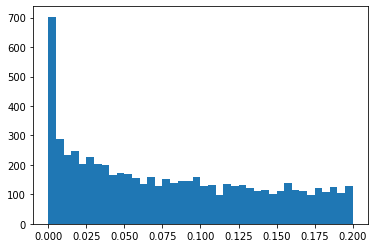

In [79]:
plt.hist(lg_log_fcs.values(), bins = 40, range = [0.0, 0.2])
plt.show()

In [65]:
liver_gene_data2.head()

,X..155060,X..653553,A1BG.1,A2M.2,AAA1.404744,AADAC.13,AADAT.51166,AASS.10157,ABAT.18,ABCA13.154664,...,ZNF85.7639,ZNF862.643641,ZNF883.169834,ZP3.7784,ZPLD1.131368,ZSCAN16.80345,ZSWIM5.57643,ZWINT.11130,psiTPTE22.387590,tAKR.389932
TCGA.2V.A95S.01,7.153715,9.630558,14.443673,18.127270,0.723864,10.414410,4.687044,5.601836,10.584448,0.000000,...,4.449581,8.080822,2.295547,6.792106,4.266337,7.072028,8.118516,8.858813,2.295547,2.909907
TCGA.2Y.A9GS.01,6.950942,9.070705,14.466773,14.927845,0.578118,13.339532,7.292245,8.815327,13.453890,4.265707,...,6.831162,7.953729,5.455436,5.110760,7.662327,6.707145,9.772858,9.298936,2.888909,8.918853
TCGA.2Y.A9GT.01,6.585654,6.714419,16.245087,14.252355,1.883621,12.764681,8.906339,11.557786,13.618564,4.706337,...,4.603668,8.389972,1.481971,3.939847,0.000000,6.303626,3.181087,8.165080,3.939847,6.398990
TCGA.2Y.A9GU.01,8.135816,8.393708,13.186655,17.896176,0.000000,12.727613,5.204297,10.440706,13.239476,2.116564,...,3.088701,9.666433,1.415921,4.870069,0.875072,6.133576,6.008868,8.818376,1.808344,1.808344
TCGA.2Y.A9GV.01,8.147571,7.605401,16.362278,13.096133,3.241871,12.794975,9.268905,9.447338,14.493701,3.775093,...,4.020449,8.629696,2.132281,5.608818,0.000000,6.899364,1.428678,6.655793,1.822975,6.910365


In [74]:
for col_name in liver_methyl_data.columns:
  #IMPUTE data
  col_data = liver_methyl_data[col_name].fillna(liver_methyl_data[col_name].mean(skipna= True))
  #take log base 2
  col_data = pd.to_numeric(np.log2(col_data.values + 1))
  liver_methyl_data[col_name] = col_data

lm_logs_solid_tum = pd.DataFrame()
lm_logs_primary_tum = pd.DataFrame()

index = 0 
for label in liver_methyl_labels:
  if label: 
    lm_logs_solid_tum = pd.concat([lm_logs_solid_tum, liver_methyl_data.iloc[[index]]], axis= 0)
  else:
    lm_logs_primary_tum = pd.concat([lm_logs_primary_tum, liver_methyl_data.iloc[[index]]], axis= 0)
  index += 1

lm_log_fcs = {}

for col_name in lm_logs_solid_tum.columns:
  fc_solid = lm_logs_solid_tum[col_name].mean()
  fc_prim = lm_logs_primary_tum[col_name].mean()
  log2fc = abs(fc_solid - fc_prim)
  lm_log_fcs[col_name] = log2fc

keep_tags = []
for tag in lm_log_fcs.keys():
  if lm_log_fcs[tag] > 0.3: 
    keep_tags.append(tag)

liver_methyl_data2 = liver_methyl_data[keep_tags]
print(liver_methyl_data2.shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(427, 2806)


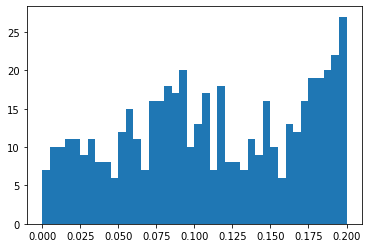

In [80]:
plt.hist(lm_log_fcs.values(), bins = 40, range = [0.0, 0.2])
plt.show()

In [75]:
mys_gene_data = mys_gene_data[keep_genes]
mys_methyl_data = mys_methyl_data[keep_tags]

for col_name in mys_gene_data.columns:
  col_data = mys_gene_data[col_name].fillna(mys_gene_data[col_name].mean(skipna= True))
  #take log base 2
  col_data = pd.to_numeric(np.log2(col_data.values + 1))
  mys_gene_data[col_name] = col_data

for col_name in mys_methyl_data.columns:
  col_data = mys_methyl_data[col_name].fillna(mys_methyl_data[col_name].mean(skipna= True))
  #take log base 2
  col_data = pd.to_numeric(np.log2(col_data.values + 1))
  mys_methyl_data[col_name] = col_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Scaling Data

In [78]:
# apply minmaxscaler to X
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

liver_gene_data2 = MinMaxScaler().fit_transform(liver_gene_data2)
print
print(liver_gene_data2[4, :])
liver_methyl_data2 = MinMaxScaler().fit_transform(liver_methyl_data2)
print(liver_methyl_data2[4, :])
mys_gene_data = MinMaxScaler().fit_transform(mys_gene_data)
print(mys_gene_data[4, :])
mys_methyl_data = MinMaxScaler().fit_transform(mys_methyl_data)
print(mys_methyl_data[4, :])

[0.71205463 0.37240781 0.81178084 ... 0.32568057 0.21556386 0.73211868]
[0.84790245 0.63218672 0.96502808 ... 0.97019101 0.53826976 0.54974047]
[0.55024113 0.53912998 0.48532257 ... 0.75239988 0.79410144 0.        ]
[0.8220264  0.7629932  0.79569676 ... 0.54513172 0.75957972 0.8050475 ]


## PCA

PCA of Liver Gene Expression Data


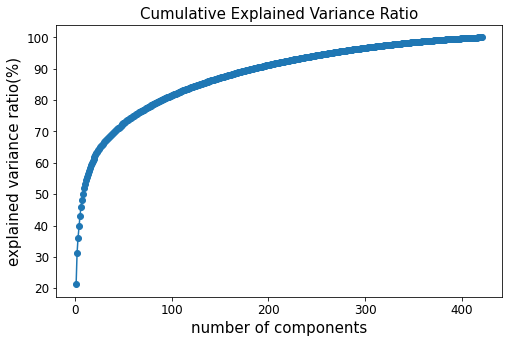

Decomposition： (421, 3696) --> (421, 150)
PCA of Liver Methylation Data


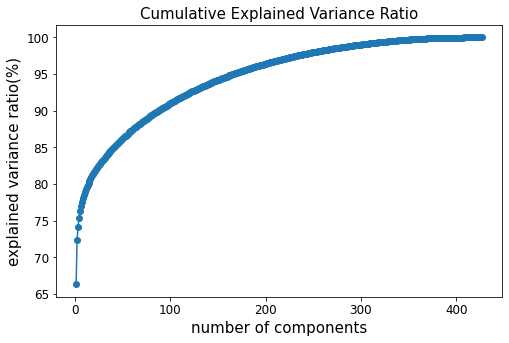

Decomposition： (427, 2806) --> (427, 150)


In [81]:
# Feature number selelction / PCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
# PCA analysis, extract main components
def PCA_n(X_scaled):
    estimator_pca = PCA(n_components=None)
    estimator_pca.fit(X_scaled) 
    evr = estimator_pca.explained_variance_ratio_ 
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(evr) + 1), np.cumsum(evr*100), "-o")
    plt.title("Cumulative Explained Variance Ratio", fontsize=15)
    plt.xlabel("number of components",fontsize=15)
    plt.ylabel("explained variance ratio(%)",fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def pcaX(X_scaled,n):#data dimension reduction
    pca = PCA(n_components=n)
    pca_X = pca.fit_transform(X_scaled)
    print('Decomposition：',X_scaled.shape,'-->',pca_X.shape)
    return pd.DataFrame(pca_X)

# Because the dimension of data is too high and there are too many features, 
# PCA method is used to extract features.

# High-dimensional data is reduced to low-dimensional data, 
# and the main information is extracted for training.
print("PCA of Liver Gene Expression Data")
PCA_n(liver_gene_data2)
pca_X1 = pcaX(liver_gene_data2, 150) # feature selection
print("PCA of Liver Methylation Data")
PCA_n(liver_methyl_data2)
pca_X2 = pcaX(liver_methyl_data2, 150) # feature selection




```
# This is formatted as code
```

# Model - Random Forest, Logistic regression, SVM, Multilayer Perceptron

==============DataSet1 - Mestery_dna-meth.csv==============
【RF_cls_model】
training time: 0.0257s
finished RandomForestClassifier model training...
evaluation:
{'accuracy': 0.9883720930232558, 'precision': 0.99375, 'recall': 0.9285714285714286, 'f1-score': 0.9583938074504113}


【LR_cls_model】
training time: 0.0512s
finished LogisticRegression model training...
evaluation:
{'accuracy': 0.9883720930232558, 'precision': 0.9375, 'recall': 0.9936708860759493, 'f1-score': 0.9634819532908705}


【SVM_cls_model】
training time: 0.0223s
finished SVC model training...
evaluation:
{'accuracy': 0.9651162790697675, 'precision': 0.85, 'recall': 0.9810126582278481, 'f1-score': 0.9020872865275142}


【MLP_cls_model】
training time: 0.7103s
finished MLPClassifier model training...
evaluation:
{'accuracy': 0.9651162790697675, 'precision': 0.85, 'recall': 0.9810126582278481, 'f1-score': 0.9020872865275142}




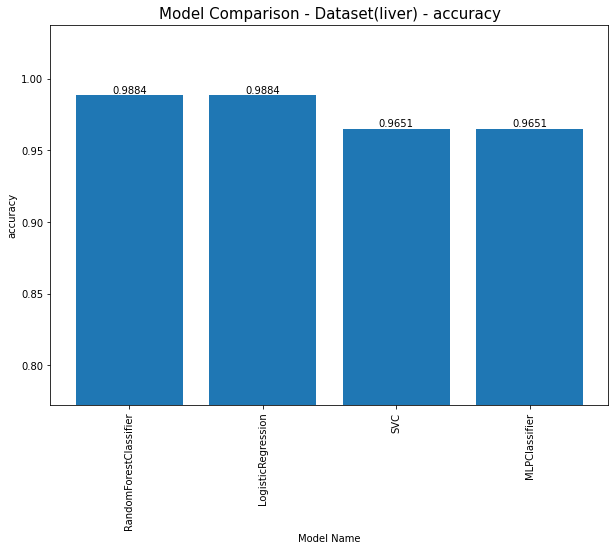


==============DataSet2 - Mystery_gene-expr.csv==============
【RF_cls_model】
training time: 0.0307s
finished RandomForestClassifier model training...
evaluation:
{'accuracy': 0.9294117647058824, 'precision': 0.9634146341463414, 'recall': 0.6666666666666666, 'f1-score': 0.7310126582278482}


【LR_cls_model】
training time: 0.0276s
finished LogisticRegression model training...
evaluation:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}


【SVM_cls_model】
training time: 0.0275s
finished SVC model training...
evaluation:
{'accuracy': 0.9764705882352941, 'precision': 0.9871794871794872, 'recall': 0.8888888888888888, 'f1-score': 0.9310064935064934}


【MLP_cls_model】
training time: 0.5695s
finished MLPClassifier model training...
evaluation:
{'accuracy': 0.9882352941176471, 'precision': 0.9935064935064934, 'recall': 0.9444444444444444, 'f1-score': 0.9673202614379085}




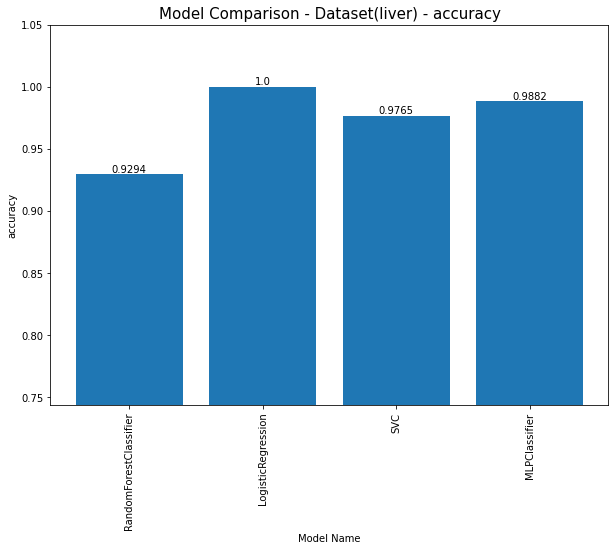

In [ ]:
## test 70% train 30%
from sklearn.model_selection import train_test_split

import time
# Define model performance evaluation methods
def evaluation(y_test,y_pred,model_type = 'regression'):
	"""
	enter real - y_test和prediction - y_pred，evaluate model
	model_type = regression #evaluate regression model
	model_type = classification  # evaluate classification model
	"""
	metrics = {}
	# if classification model
	if model_type == 'classification':
		from sklearn.metrics import classification_report
		from sklearn.metrics import accuracy_score   
		from sklearn.metrics import precision_score	
		from sklearn.metrics import recall_score	  #sensitivity
		from sklearn.metrics import f1_score		
		# metrics['cls_report'] = classification_report(y_test, y_pred)
		metrics['accuracy'] = accuracy_score(y_test,y_pred)
		metrics['precision'] =  precision_score(y_test,y_pred,average='macro')
		metrics['recall'] = recall_score(y_test,y_pred,average='macro')
		metrics['f1-score'] = f1_score(y_test,y_pred,average='macro')
		
	# if regression model
	elif model_type== 'regression':
		from sklearn.metrics import mean_squared_error
		from sklearn.metrics import mean_absolute_error
		from sklearn.metrics import r2_score
		metrics['MSE'] = mean_squared_error(y_test,y_pred)
		metrics['SCORE'] = mean_squared_error(y_test,y_pred) ** 0.5
		metrics['MAE'] = mean_absolute_error(y_test,y_pred)
		metrics['R2'] = r2_score(y_test,y_pred)
	else:
		raise Exception('model_type should be classification or regression!')
	return metrics

## Random Forest
def RF_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.ensemble import RandomForestClassifier
	RF = RandomForestClassifier(n_estimators=10)
	RF.fit(X_train,y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# evaluate model 
	# test set prediction
	y_pred_RF = RF.predict(X_test)
	# performance evaluation
	metrics= evaluation(y_test,y_pred_RF,model_type='classification')
	return RF,metrics

## Logistic Regression
def LR_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.linear_model import LogisticRegression
	LR = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
	# train model
	LR.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# predict test set result
	y_pred_LR = LR.predict(X_test)
	metrics  = evaluation(y_test,y_pred_LR,model_type='classification')
	return LR,metrics

# SVM 
def SVM_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.svm import SVC
	svc = SVC(C=1.0,kernel='rbf',probability=True)
	# train model
	svc.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# predict test set result
	y_pred_SVC = svc.predict(X_test)
	metrics  = evaluation(y_test,y_pred_SVC,model_type='classification')
	return svc,metrics

# sklearn bp - Multilayer perceptron (MLP)
def MLP_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.neural_network import MLPClassifier
	MLP = MLPClassifier(random_state=1, max_iter=300)
	# trian model
	MLP.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# predict test set result
	y_pred_MLP = MLP.predict(X_test)
	metrics  = evaluation(y_test,y_pred_MLP,model_type='classification')
	return MLP,metrics
import matplotlib.pyplot as plt
def plot_metric(metric_dic,metric = 'SCORE',dataset_name = 'None'):
	"""
	metric_dic looks like: {'model_name':{'metric_name': value}}
	"""
	# plot and comparison of indicators for each model
	x = []
	y = []
	# xtraction data
	for model_name in metric_dic.keys():
		x.append(model_name)
		y.append(metric_dic.get(model_name).get(metric))
	plt.figure(figsize=(10,7))
	# histogram
	plt.bar(x,y)
	for i,j in zip(range(len(x)),y):
		plt.text(i,j,'{:.4}'.format(j),va='bottom',ha='center')
	# title, name of axis
	plt.title(f"Model Comparison - Dataset({dataset_name}) - {metric}",fontsize=15)
	plt.xlabel("Model Name")
	plt.ylabel(metric)
	plt.xticks(rotation=90)
	plt.ylim(np.min(y)*0.8,np.max(y)*1.05)
	# save pic
	plt.savefig(f"Model Comparison - Dataset({dataset_name}) - {metric}.jpg",dpi=200)
	plt.show()

X_train1, X_test1, y_train1, y_test1 = train_test_split(liver_gene_data2, liver_gene_labels,
                                                    test_size=0.20, random_state=30)

X_train2, X_test2, y_train2, y_test2 = train_test_split(liver_methyl_data2, liver_methyl_labels,
                                                    test_size=0.20, random_state=30)

######### Dataset 1
# Select the classification model for training
cls_models = [RF_cls_model,LR_cls_model,SVM_cls_model,MLP_cls_model]
# classification model
model_type = 'classification'
eval_dic1 = {}
models1 = []
#  data set1
print("==============DataSet1 - Mestery_dna-meth.csv==============")
for model in cls_models:
	print(f"【{model.__name__}】")
	model,metrics = model(X_train1,y_train1,X_test1,y_test1)
	models1.append(model)
	# evaluation result 
	eval_dic1[type(model).__name__] = metrics.copy()
	print(f"finished {type(model).__name__} model training...")
	print("evaluation:")
	print(metrics)
	print('\n')
plot_metric(eval_dic1,metric='accuracy',dataset_name='liver')

######### Dataset 2
print("\n==============DataSet2 - Mystery_gene-expr.csv==============")
model_type = 'classification'
eval_dic2 = {}
models2 = []
cls_models = [RF_cls_model,LR_cls_model,SVM_cls_model,MLP_cls_model]
# data set2
for model in cls_models:
	print(f"【{model.__name__}】")
	model,metrics = model(X_train2,y_train2,X_test2,y_test2)
	models2.append(model)
	# result 
	eval_dic2[type(model).__name__] = metrics.copy()
	print(f"finished {type(model).__name__} model training...")
	print("evaluation:")
	print(metrics)
	print('\n')

plot_metric(eval_dic2,metric='accuracy',dataset_name='liver')